# Machine Learning Analysis

## Import modules and clean data

In [1]:
# run the data story to get data wrangling and data story variables
%run ./data_story.ipynb

E-Bikes dropped: 338834
Original scooter entries: 6510117
NA rows dropped: 130
Out of Bounds entries dropped: 52981
Before removing outliers:


<Figure size 1000x500 with 2 Axes>

Negative duration dropped: 1028
Over 12.0 hours dropped: 262
Negative or 0 distance dropped: 505391
Distance > 49.9999845312 mi dropped: 965
After removing outliers:


<Figure size 1000x500 with 2 Axes>

Total entries remaining: 5949360
Percent removed: 8.61362399477613%
Column Data types:
Device ID                           object
Vehicle Type                      category
Trip Duration                      float64
Trip Distance                      float64
Start Time                  datetime64[ns]
End Time                    datetime64[ns]
Modified Date               datetime64[ns]
Month                                 int8
Hour                                  int8
Day of Week                           int8
Council District (Start)           float64
Council District (End)             float64
Year                                 int16
Census Tract Start                  object
Census Tract End                    object
dtype: object


<Figure size 1000x500 with 2 Axes>

<Figure size 640x480 with 1 Axes>

Number of Census Tract Starts: 256
Number of Census Tract Ends: 257
Number of unique Census Tracts in the data: 271


<Figure size 640x480 with 1 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 640x480 with 1 Axes>

Top 4 starting location counts by day:


<Figure size 1000x500 with 4 Axes>

Top 4 ending location counts by day:


<Figure size 1000x500 with 4 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

In [2]:
# import modules
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.metrics import r2_score

## Prepare data for prediction

The function below was created to generate the number of rides in a census tract per hour.  Then the date columns can be used as features, and the number of rides as target.

In [3]:
# create a row for every hour
def ct_by_hour(df, census_tract, sample='H', end=False):
    '''Returns dataframe with the number of rides per hour
    df: DataFrame--the source DataFrame (i.e. scooters)
    census_tract: String--the census tract number
    sample: String--the desired sample rate (see pandas.DataFrame.resample documentation)
    end: boolean--If true, use census tract end for resampling'''
    
    if end:
        ct_df = pd.DataFrame(df[df['Census Tract End']==census_tract])
    else:
        ct_df = pd.DataFrame(df[df['Census Tract Start']==census_tract])
    
    # add a n column to sample
    ct_df['n'] = 1
    
    # resample at sample rate.  Use mean for distance/duration.  Also use mean to preserve datetime related values.
    # Use sum for n
    ct_df = ct_df.set_index('Start Time').resample(sample).agg({'Trip Duration': np.mean, 
                                                               'Trip Distance': np.mean,
                                                               'Month': np.mean,
                                                               'Day of Week': np.mean,
                                                               'Hour': np.mean,
                                                               'Year': np.mean,
                                                               'n': np.sum})
    
    
    # drop nas
    ct_df = ct_df.dropna()
    
    # Add day of month
    ct_df['Day of Year'] = ct_df.index.dayofyear
    
    # Return date and time columns.  Don't use duration and distance, as they would make better targets
    return ct_df[['Year', 'Day of Year', 'Day of Week', 'Hour', 'n']]


## Linear and Ridge Regression

In [4]:
def run_regression(regressor, census_tract, source_df=scooters, sample_rate='H'):
    '''Runs desired regression on the specified census tract. Plots results and prints score
    Classifier: desired sklearn classifier
    census_tract: string--census tract number
    source_df: DataFrame--source dataframe, default is scooters'''
    
    # Create features and target
    df = ct_by_hour(source_df, census_tract, sample=sample_rate)
    

    X = df[['Year', 'Day of Year', 'Day of Week', 'Hour']]
    y = df['n']

    # Split into test and training data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    

    # Fit classifier to training data
    regressor.fit(X_train, y_train)

    # Predict on test data
    y_pred_reg = regressor.predict(X_test)

    plt.figure(figsize=(10, 5))
    
    plt.scatter(y_test, y_pred_reg)
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.plot([0, 750], [0, 750], '--k')

    plt.tight_layout()
    plt.show()
    plt.close()

    print(f'Confidence score of {r2_score(y_test, y_pred_reg)} \n')
    
    return regressor, X, y

In [5]:
def mape_error(y_actual, y_pred):
    mape = np.sum(abs(y_actual - y_pred) / abs(y_actual)) / len(y_actual)
    return mape

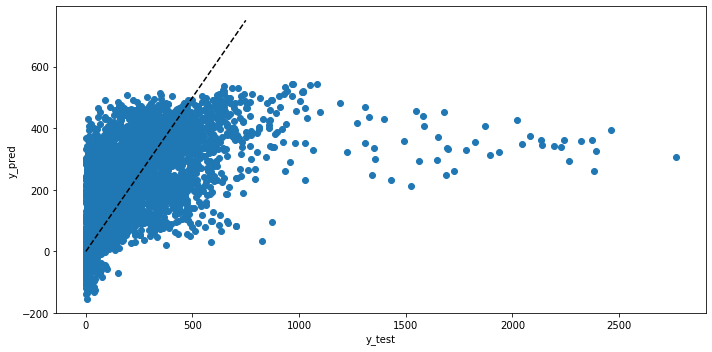

Confidence score of 0.27801549939689374 



0
Year         219.320397
Day of Year    0.413987
Day of Week   17.178929
Hour          15.277765

In [6]:
# Run a linear regression on the most popular census tract
linreg, linreg_X, linreg_y= run_regression(LinearRegression(), '48453001100');

# print the coefficients 
pd.DataFrame(linreg.coef_, linreg_X.columns)

Running the Linear Regression as in the code above produces a dismal r2 score of .28.

### One Hot Encoding

Use a One Hot Encoder to expand the date features into categorical data.  The function below creates a One Hot Encoder to split the categories into Year, Day of Year, Day of Week, and Hour.

In [7]:
def expanded_linreg(ct, sample_rate='H'):
    # Create features and target
    if sample_rate == 'D':
        df = ct_by_hour(scooters, ct, sample='D')
        X = df[['Year', 'Day of Year', 'Day of Week']]
        y = df['n']
    else:
        df = ct_by_hour(scooters, ct)
        X = df[['Year', 'Day of Year', 'Day of Week', 'Hour']]
        y = df['n']
    # initiate a OneHotEncoder to transform X into categorical data.
    ohe = OneHotEncoder(categories='auto')


    # fit transform the ohe to create a categorical X
    X_vectorized = ohe.fit_transform(X).toarray()

    # Split into test and training data
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.4, random_state=42)

    # Fit classifier to training data
    # Using Linear regression 
    reg = LinearRegression()
    reg.fit(X_train, y_train)

    # Predict on test data
    y_pred = reg.predict(X_test)
    print(max(y_pred))
    print(max(y_test))

    plt.subplot(1,2,1)
    plt.scatter(y_test, y_pred)
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.plot([0, max(y_pred)], [0, max(y_pred)], '--k')
    plt.title(str(reg))
    
    # revert the x_test back to dates to plot
    if sample_rate == 'D':
        X_test_dates = pd.DataFrame(ohe.inverse_transform(X_test), columns=['year', 'day of year', 'day of week'])
        X_test_dates['month'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%m')
        X_test_dates['day'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%d')
        X_test_dates = pd.to_datetime(X_test_dates[['year', 'month', 'day']])
    else:
        X_test_dates = pd.DataFrame(ohe.inverse_transform(X_test), columns=['year', 'day of year', 'day of week', 'hour'])
        X_test_dates['month'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%m')
        X_test_dates['day'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%d')
        X_test_dates = pd.to_datetime(X_test_dates[['year', 'month', 'day', 'hour']])
    
    
    plt.subplot(1,2,2)
    plt.scatter(X_test_dates, y_pred, color='b', alpha=0.5, label='y predicted')
    plt.scatter(X_test_dates, y_test, color='r', alpha=0.5, label='y test')
    plt.xticks(rotation=90)
    plt.legend()
    #plt.xlim(dt.date(2019, 6, 1), dt.date(2019, 6, 14))
    plt.xlabel('Date')
    plt.ylabel('Number of Rides')
    
    
    plt.show()
    plt.close()

    print(f'Confidence score for categorical X with Linear Regression: {r2_score(y_test, y_pred)}')
    print(f'MAPE: {mape_error(y_test, y_pred)}')
    
    if sample_rate == 'D':
        coeff = pd.DataFrame(reg.coef_, 
                             ohe.get_feature_names(['year', 'Day of Year', 'day of week']), 
                             columns=['Coefficient'])
    
    else:
        coeff = pd.DataFrame(reg.coef_, 
                             ohe.get_feature_names(['year', 'Day of Year', 'day of week', 'hour']), 
                             columns=['Coefficient'])
    return reg, coeff

1.6278404773221872e+17
23594


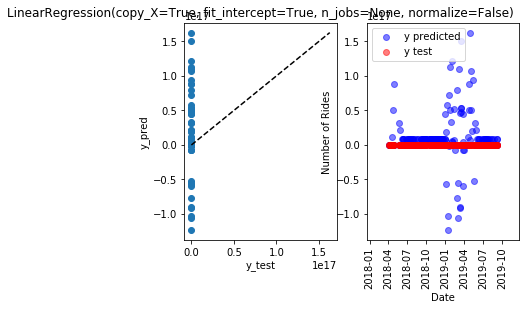

Confidence score for categorical X with Linear Regression: -7.412046903424187e+25
MAPE: 6441276707325.678
                  Coefficient
year_2018.0      6.058402e+13
year_2019.0      6.058402e+13
Day of Year_1    3.626620e+16
Day of Year_2    9.820312e+15
Day of Year_3   -6.497701e+16
Day of Year_4   -8.880120e+15
Day of Year_5   -8.880120e+15
Day of Year_6   -3.421949e+15
Day of Year_7   -8.880120e+15
Day of Year_8    4.894781e+16
Day of Year_9   -8.880120e+15
Day of Year_10  -8.880120e+15
Day of Year_11  -8.880120e+15
Day of Year_12  -8.880120e+15
Day of Year_13  -8.880120e+15
Day of Year_14  -1.324687e+17
Day of Year_15  -1.110952e+17
Day of Year_16  -8.880120e+15
Day of Year_17  -8.880120e+15
Day of Year_18  -8.880120e+15
Day of Year_19   6.421853e+16
Day of Year_20  -8.880120e+15
Day of Year_21  -1.086449e+16
Day of Year_22  -8.880120e+15
Day of Year_23  -8.880120e+15
Day of Year_24   1.036477e+17
Day of Year_25   4.140247e+16
Day of Year_26  -8.880120e+15
Day of Year_27  -8.88012

In [8]:
# Run the classifier on 3 census tracts
reg, coeff = expanded_linreg('48453001100', sample_rate='D')
# expanded_linreg('48453000601')
# expanded_linreg('48453000603')

print(coeff)

Expanding the features using One Hot Encoding doubled the R2 score.  However, the coefficients of the linear regression yeilded very similar coefficients across each category.

### Ridge Regression
While similar coefficients is not necessarily a problem for the model, using Ridge regularization may improve results.  I try this below:

In [9]:
def mean_squared_error(truth, predicted):
    m = truth.shape[0]
    mse = (np.sum((predicted - truth) ** 2)) / (2 * m)
    return mse


# create a dataframe 
def make_xy(n_cts, sample_rate='H'):
    # initialize dataframe of top cts
    
    if sample_rate == 'D':
        top_ct_df = pd.DataFrame(columns=['Year', 'Month', 'Day of Month', 'Day of Week', 'n', 'Census Tract'])
    else:
        top_ct_df = pd.DataFrame(columns=['Year', 'Month', 'Day of Month', 'Day of Week', 'Hour', 'n', 'Census Tract'])
    
    for ct in census_starts.head(n_cts).index.values:
        ct_df = ct_by_hour(scooters, ct, sample=sample_rate)
        ct_df['Census Tract'] = ct
        top_ct_df = top_ct_df.append(ct_df, sort=False)
    
    # pivot dataframe so that each ct is a column
    y = top_ct_df.pivot(columns='Census Tract', values='n')

    # fill NAs with 0
    y = y.fillna(0)

    # make x from the date data
    X = pd.DataFrame(index=y.index)
    X['Year'] = X.index.year
    X['Day of Year'] = X.index.dayofyear
    X['Day of Week'] = X.index.dayofweek
    X['Hour'] = X.index.hour
    
    return X, y

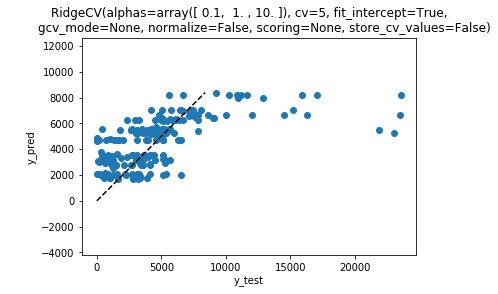

Average confidence score for categorical X with Ridge regression and 5-fold cross validation: 0.3550699785272473
MSE: Census Tract
48453001100    5.418618e+06
dtype: float64
MAPE: Census Tract
48453001100    14.071466
dtype: float64


year_2018    year_2019  day of year_1  day of year_2  \
Census Tract                                                           
48453001100  -1741.429764  1741.429764            0.0            0.0   

              day of year_3  day of year_4  day of year_5  day of year_6  \
Census Tract                                                               
48453001100             0.0    -228.246322    -222.685396            0.0   

              day of year_7  day of year_8  ...  day of year_364  \
Census Tract                                ...                    
48453001100     -196.932491            0.0  ...      -103.110558   

              day of year_365  day of week_0  day of week_1  day of week_2  \
Census Tract                                                                 
48453001100               0.0     -840.35986   -1107.056429    -776.533857   

              day of week_3  day of week_4  day of week_5  day of week_6  \
Census Tract                                                               
48453001100      -76.522621     299.092274    1822.922092     678.458402   

              hour_0  
Census Tract          
48453001100      0.0  

[1 rows x 375 columns]

In [10]:
X, y = make_xy(1, sample_rate='D')

ohe = OneHotEncoder(categories='auto')

# fit transform the ohe to create a categorical X
X_vectorized = ohe.fit_transform(X).toarray()

    # Split into test and training data
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.4, random_state=42)

    # Fit classifier to training data
reg = RidgeCV(cv=5)
reg.fit(X_train, y_train)

    # Predict on test data
y_pred = reg.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.plot([0, max(y_pred)], [0, max(y_pred)], '--k')
plt.title(str(reg))
plt.axis('equal')
plt.show()
plt.close()

print(f'Average confidence score for categorical X with Ridge regression and 5-fold cross validation: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAPE: {mape_error(y_test, y_pred)}')
    
pd.DataFrame(reg.coef_, columns=ohe.get_feature_names(['year', 'day of year', 'day of week', 'hour']), index=y.columns)

The r2 score for ridge regression was very similar to the results of the linear regression.  Both were about 0.62.  Try improving by tuning the alpha hyperparameter

### Hyperparameter Tuning with grid search

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge # Use 'plain' ridge because CV will be completed by gridsearchcv
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso

# Make a list of alpha values to try
params_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

#Ridge
ridge = Ridge()
ridge_tune = GridSearchCV(ridge, params_ridge, cv=5)
ridge_tune.fit(X_train, y_train)
y_pred_tune = ridge_tune.predict(X_test)
print(ridge_tune.best_estimator_)
print(ridge_tune.best_params_)
print(ridge_tune.best_score_)
print(f'R2 prediction score {r2_score(y_test, y_pred_tune)}')
print(f'MAPE: {mape_error(y_test, y_pred_tune)}')


# improve the ridge estimator.  Since 1 was the best alpha, try some more values near one
params_ridge_2 = {'alpha': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 5]}
ridge_tune_2 = GridSearchCV(ridge, params_ridge_2, cv=5)
ridge_tune_2.fit(X_train, y_train)
y_pred_tune_2 = ridge_tune_2.predict(X_test)
print(ridge_tune_2.best_estimator_)
print(ridge_tune_2.best_params_)
print(ridge_tune_2.best_score_)
print(f'R2 prediction score {r2_score(y_test, y_pred_tune_2)}')
print(f'MAPE: {mape_error(y_test, y_pred_tune_2)}')

# Try grid searching on linear regression
params_linreg = {'fit_intercept': [True, False], 'normalize': [True, False]}
linreg_tune = GridSearchCV(linreg, params_linreg, cv=5)
linreg_tune.fit(X_train, y_train)
y_pred_linreg_tune = linreg_tune.predict(X_test)
print(linreg_tune.best_estimator_)
print(linreg_tune.best_score_)
print(f'linreg_tune R2 prediction score {r2_score(y_test, y_pred_linreg_tune)}')
print(f'MAPE: {mape_error(y_test, y_pred_linreg_tune)}')

# # Try grid searching on a bayesian ridge regression
# params_b_ridge = {
#     'alpha_1': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
#     'alpha_2': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
#     'lambda_1': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
#     'lambda_2': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
# }
# b_ridge = BayesianRidge()
# b_ridge_tune = GridSearchCV(b_ridge, params_b_ridge, cv=5)
# b_ridge_tune.fit(X_train, y_train)
# y_pred_b_ridge_tune = b_ridge_tune.predict(X_test)
# print(b_ridge_tune.best_estimator_)
# print(b_ridge_tune.best_score_)
# print(f'Bayesian Ridge R2 score: {r2_score(y_test, y_pred_b_ridge_tune)}')

# Try a Lasso Regression --actually don't, it does not converge.
# lasso = Lasso() #max_iter=10000 did not converge
# lasso_tune = GridSearchCV(lasso, params_ridge, cv=5) # start with the ridge params
# lasso_tune.fit(X_train, y_train)
# y_pred_tune_lasso = lasso_tune.predict(X_test)
# print(lasso_tune.best_estimator_)
# print(lasso_tune.best_score_)
# print(r2_score(y_test, y_pred_tune_lasso))


/Users/trevor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
{'alpha': 10}
0.3783562476967938
R2 prediction score 0.3550699785272473
MAPE: Census Tract
48453001100    14.071466
dtype: float64
Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
{'alpha': 5}
0.37917959879596386
R2 prediction score 0.35625635745880246
MAPE: Census Tract
48453001100    13.416749
dtype: float64
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
-2.0347053917787786e+25
linreg_tune R2 prediction score -3.2717663390982426e+25
MAPE: Census Tract
48453001100    2.727078e+12
dtype: float64


/Users/trevor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [12]:
# get dates out of X train to plot
X_test_dates = pd.DataFrame(ohe.inverse_transform(X_test), columns=['year', 'day of year', 'day of week', 'hour'])

X_test_dates['month'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%m')
X_test_dates['day'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%d')
X_test_dates = pd.to_datetime(X_test_dates[['year', 'month', 'day', 'hour']])

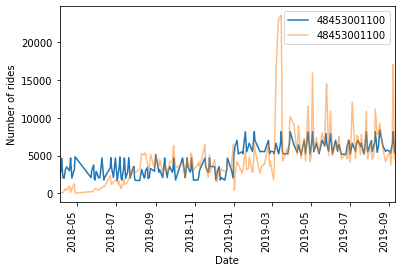

In [13]:
# Create a DataFrame of predictions
predictions_df = pd.DataFrame(y_pred, columns=y.columns, index=X_test_dates)

# Plot date vs number of rides predicted and actual rides
for i, ct in enumerate(predictions_df.columns):
    predictions_df.plot(y=ct)
    y_test[ct].plot(alpha=0.5)
    plt.xticks(rotation=90)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Number of rides')
    plt.show()

## Batch Gradient Descent

### Define Batch Gradient Descent Functions

In [14]:
def mean_squared_error(truth, predicted):
    m = truth.shape[0]
    mse = (np.sum((predicted - truth) ** 2)) / (2 * m)
    return mse

def batch_gradient_descent(X, y, learn_rate, n_iter):
    
    weights = np.zeros(X.shape[1])
    
    history = []
    m = len(y)
    
    predict = lambda x: np.dot(x, weights)
    derivative = lambda loss: (X.T.dot(loss)) / m
    
    for i in range(n_iter):
        hypothesis = predict(X)
        loss = hypothesis - y
        weights = weights - learn_rate * derivative(loss)
        
        
        if i % 50 == 0:
            history.append(mean_squared_error(X.dot(weights), y))
    
    return predict, history

### Create data set and predictions

In [15]:
# Make Xy for the top census tract
X, y = make_xy(1, sample_rate='D')

# One Hot encode X
ohe = OneHotEncoder(categories='auto') 
X_vectorized = ohe.fit_transform(X).toarray()

# convert y to series by extracting census tract data
y = y.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.4)

In [16]:
# Run the predictor
predictor, history = batch_gradient_descent(X_train, y_train, 0.05, 50000)

learning rate: 0.05, n_iterations: 50,000, mean squared error: 5543660.773803875
r squared score: 0.18994150445012847
MAPE: 1.3610601412765475


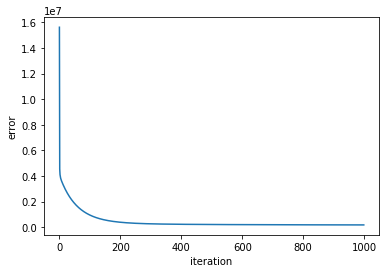

In [17]:
# Evaluate the predictor
y_pred = predictor(X_test)
print(f'learning rate: 0.05, n_iterations: 50,000, mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'r squared score: {r2_score(y_test, y_pred)}')
print(f'MAPE: {mape_error(y_test, y_pred)}')

plt.plot(history)
plt.xlabel('iteration')
plt.ylabel('error')
plt.show()

This r2 score is slightly lower than the ridge regression, but it may be able to be improved by hyperparameter tuning.

### Tune Hyperparameters

In [18]:
# define a function to test hyperparameters to find best convergence of the model:
import time

def test(X, y, lrates, niterations):
    record = []
    
    for niter in niterations:
        for lrate in lrates:
            start = time.time()
            weights, records = batch_gradient_descent(X, y, lrate, niter)
            delta = time.time() - start
            record.append(dict(lrate=lrate, niter=niter, w=weights, history=records, time=delta))
    
    return record



In [19]:
# Define hyperparameter values to try
learn_rates = [10, 1, 0.5, 0.1, 0.01, 0.001, 0.0001]
n_iterations = [10000, 20000, 50000]

# Test these values
records = test(X_train, y_train, learn_rates, n_iterations)

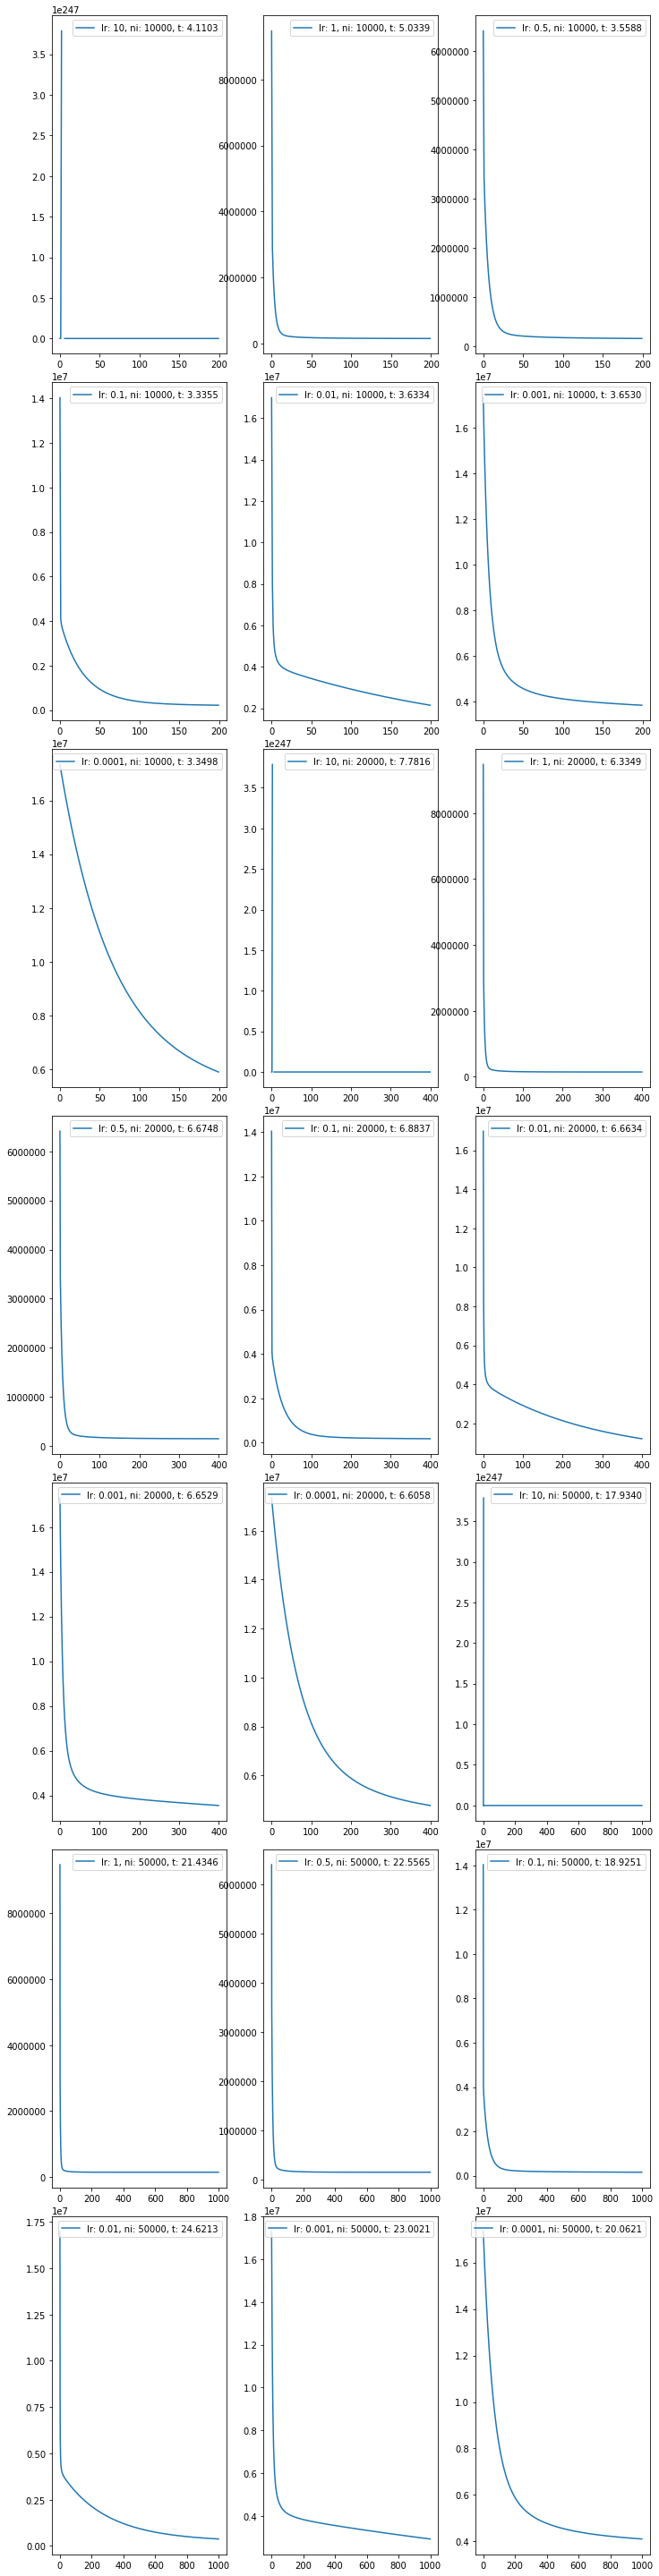

In [20]:
# Plot results
figure, plots = plt.subplots(len(learn_rates), len(n_iterations), figsize=(10,40))
figure.tight_layout()
plots = plots.flatten()
for i, record in enumerate(records):
    time = "{0:.4f}".format(record['time'])
    label = 'lr: {0}, ni: {1}, t: {2}'.format(record["lrate"], record["niter"], time)
    plots[i].plot(record['history'], label=label)
    plots[i].legend(loc='upper right')


In [21]:
import tabulate
time_sorted_records = sorted(records, key=lambda k: k['time']) 
tab_data = time_sorted_records.copy()
for r in tab_data:
    r['cost'] = r['history'][-1]
    del r['history']
    del r['w']
print(tabulate.tabulate(tab_data, headers={'lrate': 'lrate', 'niter': 'niter', 'time': 'elapsed time', 'cost': 'cost'}))

  lrate    niter    elapsed time              cost
-------  -------  --------------  ----------------
 0.1       10000         3.33554  220865
 0.0001    10000         3.34982       5.89885e+06
 0.5       10000         3.55875  154964
 0.01      10000         3.63338       2.14517e+06
 0.001     10000         3.653         3.8283e+06
10         10000         4.11025       0
 1         10000         5.0339   147748
 1         20000         6.33493  146632
 0.0001    20000         6.60579       4.77943e+06
 0.001     20000         6.65285       3.54873e+06
 0.01      20000         6.66337       1.21648e+06
 0.5       20000         6.67477  147738
 0.1       20000         6.88366  180310
10         20000         7.78155       0
10         50000        17.934         0
 0.1       50000        18.9251   154898
 0.0001    50000        20.0621        4.10707e+06
 1         50000        21.4346   146608
 0.5       50000        22.5565   146612
 0.001     50000        23.0021        2.91936e+06

The model converges fastests at 20,000 iterations with a learning rate of 1. So we'll use these parameters to run the model one more time.

In [22]:
predictor_tuned, history_tuned = batch_gradient_descent(X_train, y_train, 1, 20000)

# Evaluate the predictor
y_pred = predictor_tuned(X_test)
print(f'learning rate: 1, n_iterations: 20,000, mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'r squared score: {r2_score(y_test, y_pred)}')
print(f'MAPE: {mape_error(y_test, y_pred)}')

learning rate: 1, n_iterations: 20,000, mean squared error: 6261476.171050164
r squared score: 0.08505188646997286
MAPE: 1.5979503051389532


### Best result with Batch Gradient Descent:

learning rate: 1, n_iterations: 10,000, mean squared error: 6261476.171050164
r squared score: 0.08505188646997286
MAPE: 1.5979503051389532


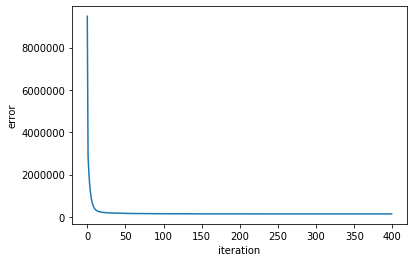

In [23]:
# Evaluate the predictor
y_pred_tuned = predictor_tuned(X_test)
print(f'learning rate: 1, n_iterations: 10,000, mean squared error: {mean_squared_error(y_test, y_pred_tuned)}')
print(f'r squared score: {r2_score(y_test, y_pred_tuned)}')
print(f'MAPE: {mape_error(y_test, y_pred_tuned)}')

plt.plot(history_tuned)
plt.xlabel('iteration')
plt.ylabel('error')
plt.show()

## Using Facebook Prophet

In [24]:
def prophesy(census_tract, df=scooters, sample_rate='H', forecast_periods=30, add_holidays=False, plot=True, plot_components=True, cross_validate=True):
    '''Use Facebook prophet on the specified census tract:
    df: source DataFrame
    census_tract:  string of census tract number
    sample_rate: rate at which to run the sample, defaults to "H" for hourly, can also be "D" for daily
    forecast_periods: number of periods to forecast after primary data
    add_holiday: default to false, can be dataframe that follows fbprophet holiday dataframe conventions
    plot: if True, plot the results
    plot_components: if True, plot the components'''
    
        #Plot the location of the census tract
    fig, (ax2) = plt.subplots()
    map_df.plot(color='0.9', edgecolor='0.0', ax=ax2)
    ax2.axis('off')
    ax2.set(title='Location of ' + census_tract)
    map_df[map_df['CTIDFP00'] == census_tract].plot(color='g', ax=ax2)
    bbox = (-97.919881, -97.589348, 30.139918,30.426626)
    plt.xlim(bbox[0], bbox[1])
    plt.ylim(bbox[2], bbox[3])
    plt.show()
    
    
    # Use ct by hour function to get hourly data for a census tract
    ct_x_by_hour = ct_by_hour(df,census_tract, sample=sample_rate)['n'].reset_index()
    ct_x_by_hour.columns = ['ds', 'y']

    # import facebook prophet
    from fbprophet import Prophet

    # Create a holidays dataframe that includes non-standard holidays (i.e. SXSW)
    sxsw = pd.DataFrame({
        'holiday': 'sxsw',
        'ds': pd.to_datetime(['2017-03-10', '2018-03-09', '2019-03-08']),
        'lower_window': 0,
        'upper_window': 9
    })
    
    if add_holidays is False:
        holidays= sxsw
    else:
        holidays = sxsw.concat(add_holidays)


    # instatiate prophet model, use mult seasonality because the magnitude of peaks/valleys increases
    fbp = Prophet(holidays=holidays, yearly_seasonality=True, seasonality_mode='multiplicative')

    # add standard US holidays
    fbp.add_country_holidays(country_name='US')

    # fit to dataframe
    fbp.fit(ct_x_by_hour)
    
    # create a dataframe for predicting
    future = fbp.make_future_dataframe(periods=forecast_periods, freq=sample_rate)

    # create a forecast
    forecast = fbp.predict(future)

    from fbprophet.plot import add_changepoints_to_plot

    # Plot the results and the components
    if plot is True:
        fig1 = fbp.plot(forecast)
        a = add_changepoints_to_plot(fig1.gca(), fbp, forecast)
    
    if plot_components is True:
        fig2 = fbp.plot_components(forecast)
        
    if cross_validate is True:
        
        # Run cross validation
        from fbprophet.diagnostics import cross_validation, performance_metrics
        from fbprophet.plot import plot_cross_validation_metric
        
        df_cv = cross_validation(fbp, initial='500 days', horizon='7 days')
        performance = performance_metrics(df_cv)
        
        # plot
        fig3 = plot_cross_validation_metric(df_cv, metric='mape')
        
        print(f'{census_tract} r2 score: {r2_score(df_cv.y, df_cv.yhat)}')
        print(f'MAPE: {mape_error(df_cv.y, df_cv.yhat)}')
        return fbp, performance, df_cv, forecast
    else:
        return fbp, forecast

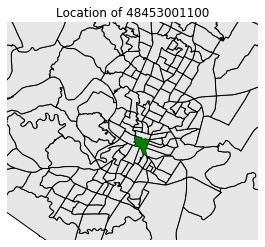

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-08-17 12:00:00 and 2019-09-04 00:00:00


48453001100 r2 score: 0.2890065970561313
MAPE: 0.24695206019865865


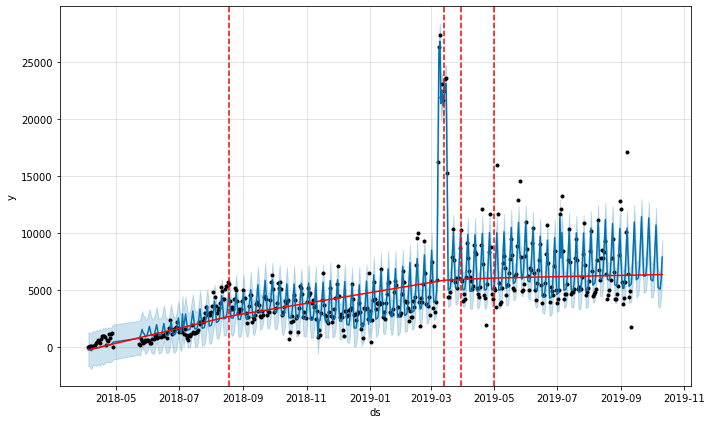

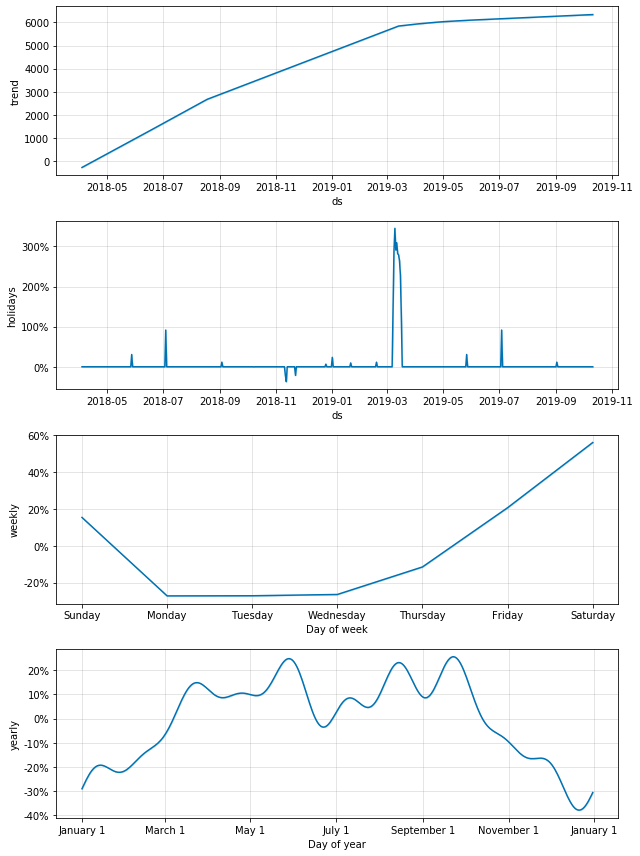

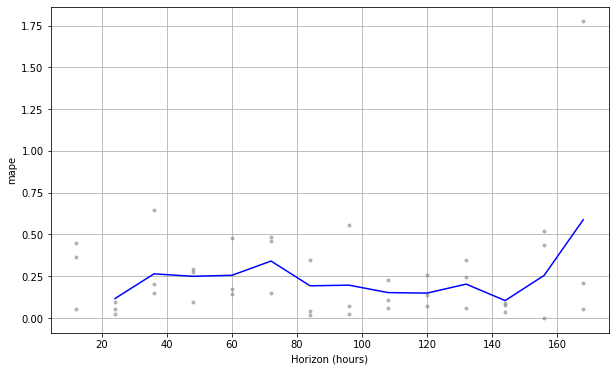

In [35]:
fbp_1100, perf_1100, df_cv_1100, forecast_1100 = prophesy('48453001100', sample_rate='D')

SXSW in March is a major outlier, what if instead of using holiday seasonality to handle it, we remove the outliers?

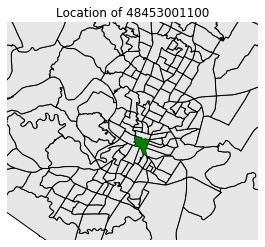

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-08-17 12:00:00 and 2019-09-04 00:00:00


48453001100 r2 score: 0.4229256497149243
MAPE: 0.2757725849062164


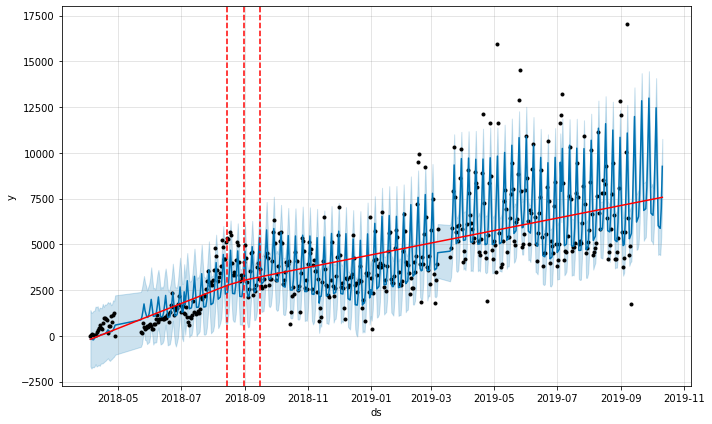

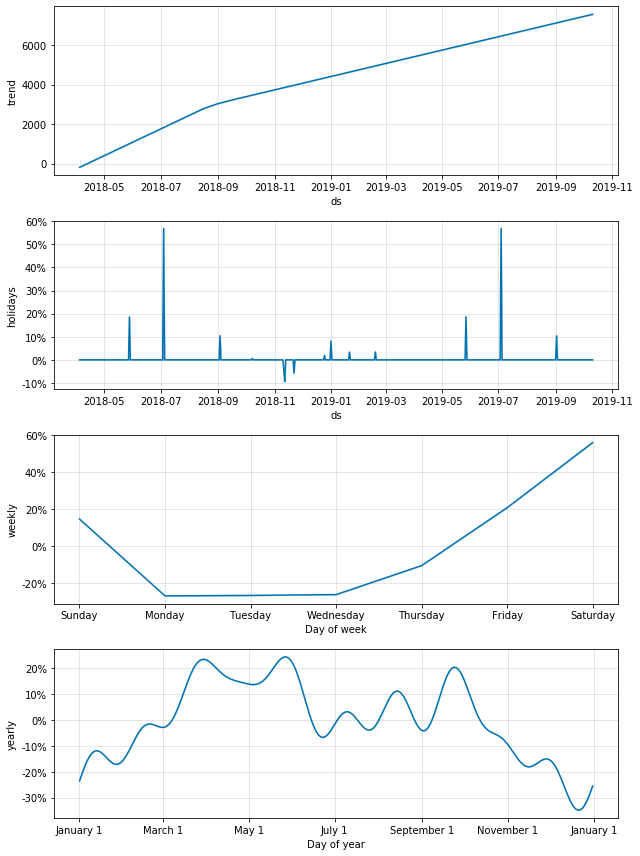

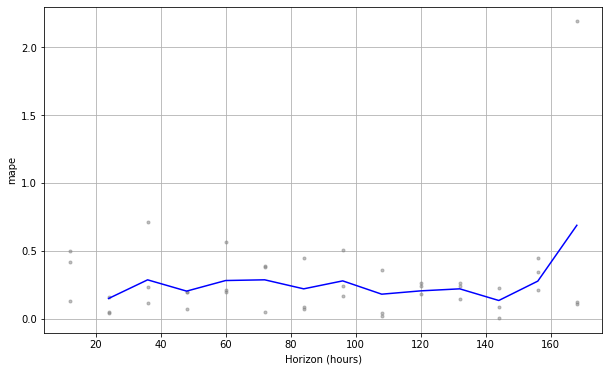

In [127]:
# define scooters to drop
to_drop = scooters[(scooters['Start Time'] >= '2019-03-08') & (scooters['Start Time'] <= '2019-03-19')].index

scooters_no_sxsw = scooters.drop(to_drop, axis=0)

fbp_1100_nosxsw, perf_1100_nosxsw, df_cv_1100_nosxsw, forecast_1100_nosxsw = prophesy('48453001100', df=scooters_no_sxsw, sample_rate='D')


Removing SXSW doesn't appear to greatly reduce the mean error--this is likely because the 'Holidays' model addresses this.

## Business Impact

Because these forecasts are the sum total of all scooter providers, it would be naive for one company to assume that they could place the predicted number of scooters and optimize their utilization.  However, these numbers can be used for a scooter provider to determine where to place what percentage of their fleet.

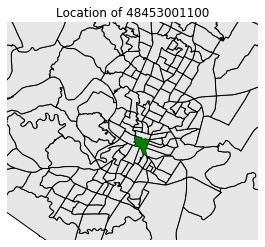

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-08-17 12:00:00 and 2019-09-04 00:00:00


48453001100 r2 score: 0.2890065970561313
MAPE: 0.24695206019865865


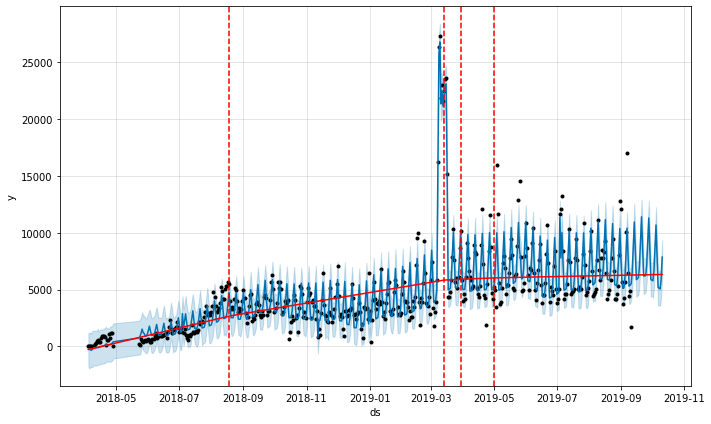

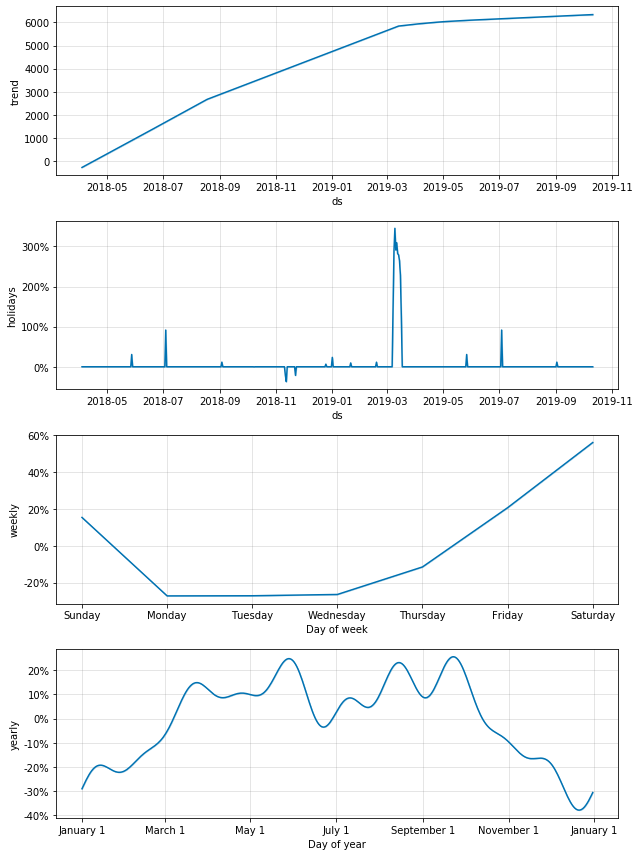

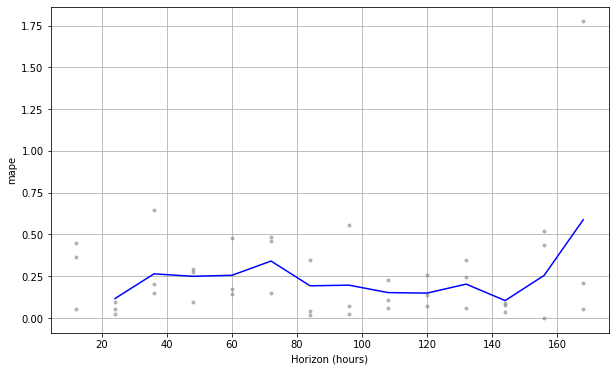

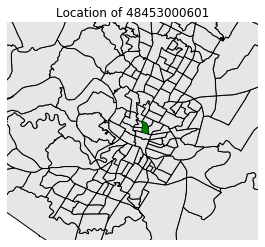

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000601 r2 score: 0.04085007761200343
MAPE: 0.34282422881404034


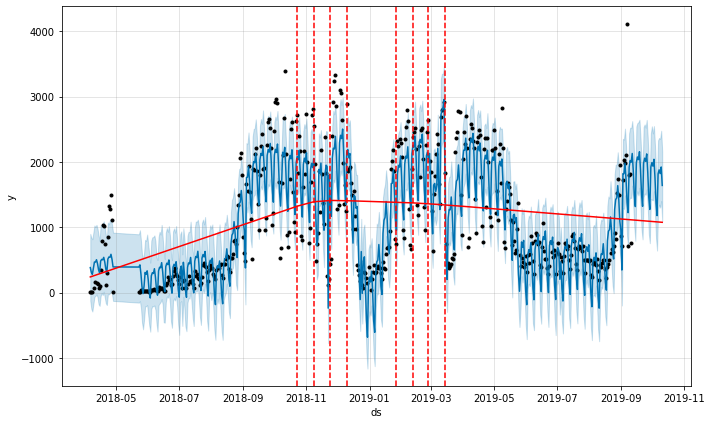

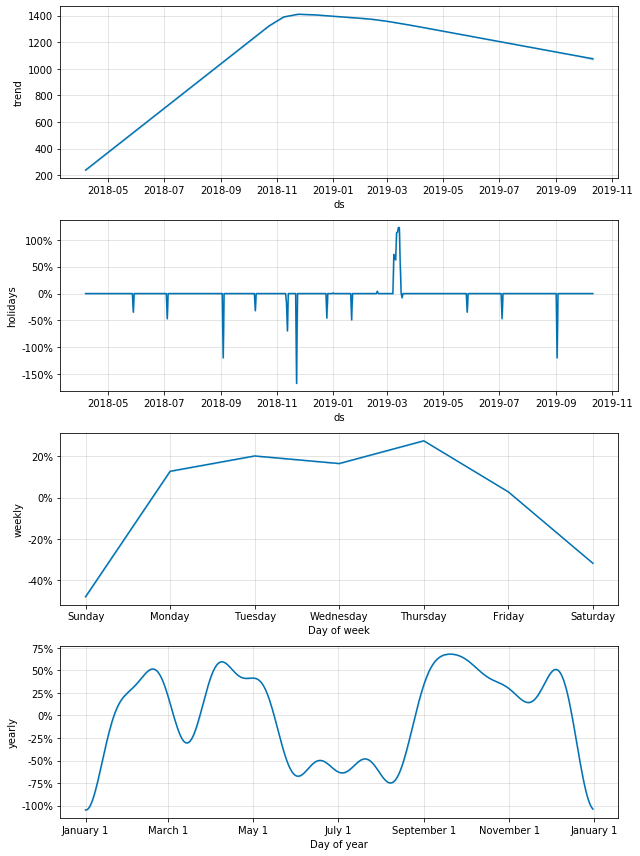

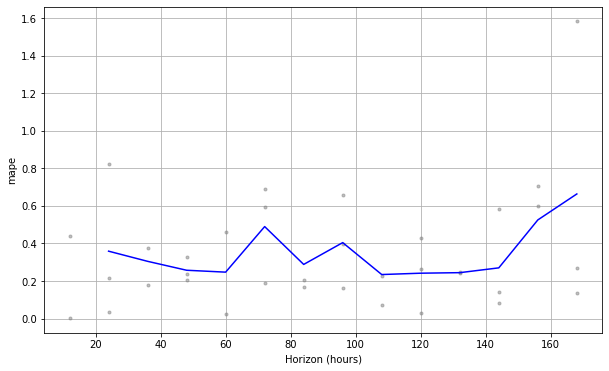

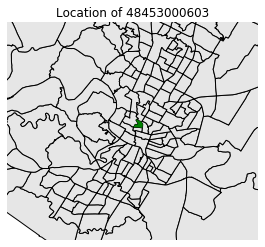

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000603 r2 score: 0.3482429726404709
MAPE: 0.24163398129421929


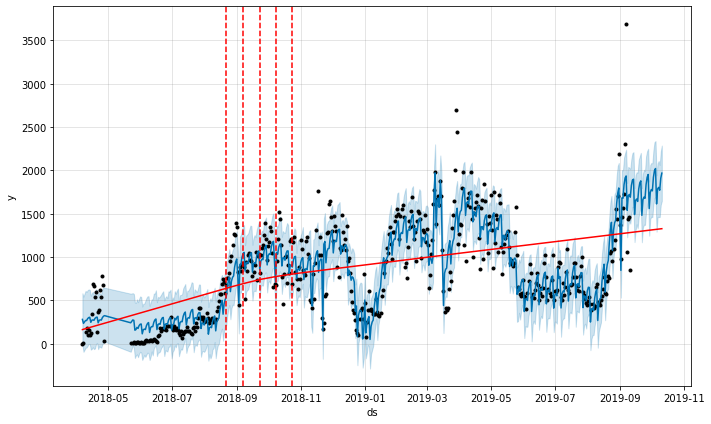

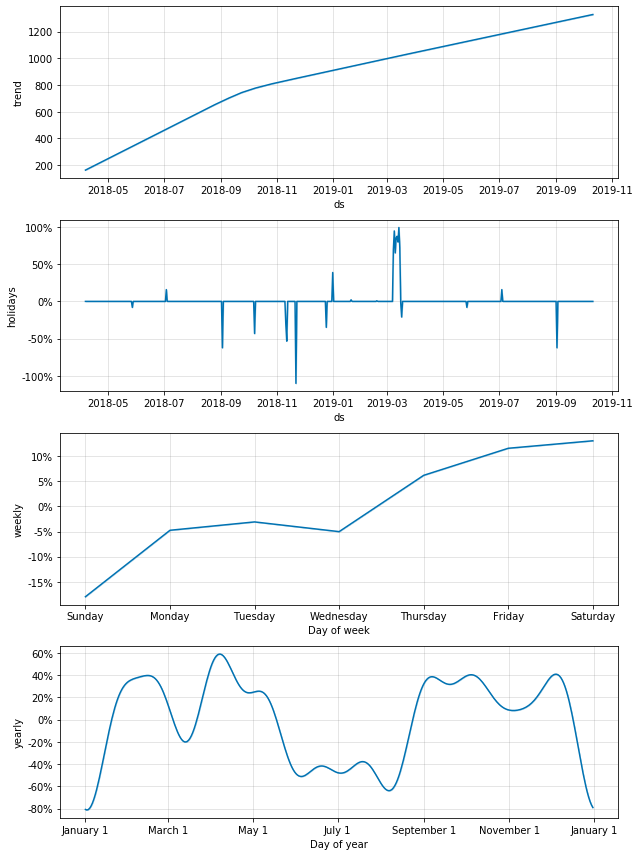

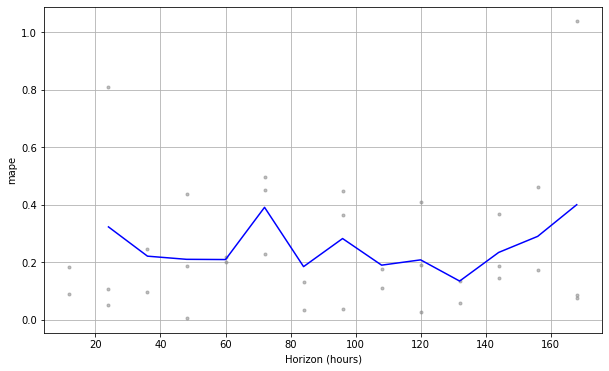

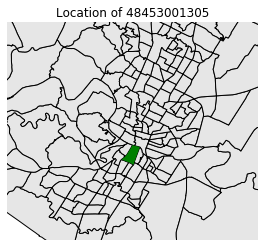

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453001305 r2 score: 0.22968826558733013
MAPE: 0.26220272445999676


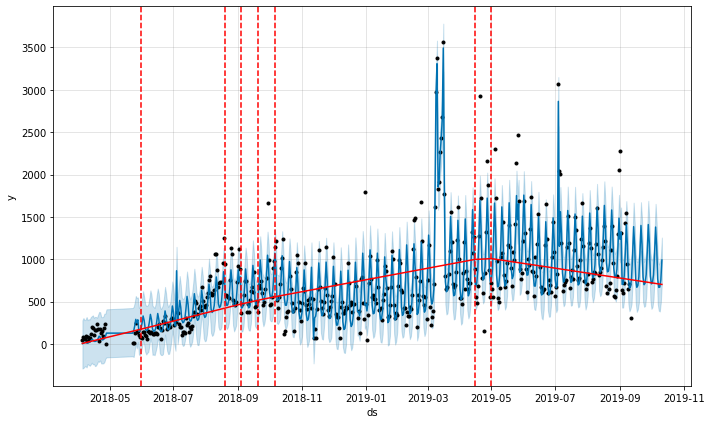

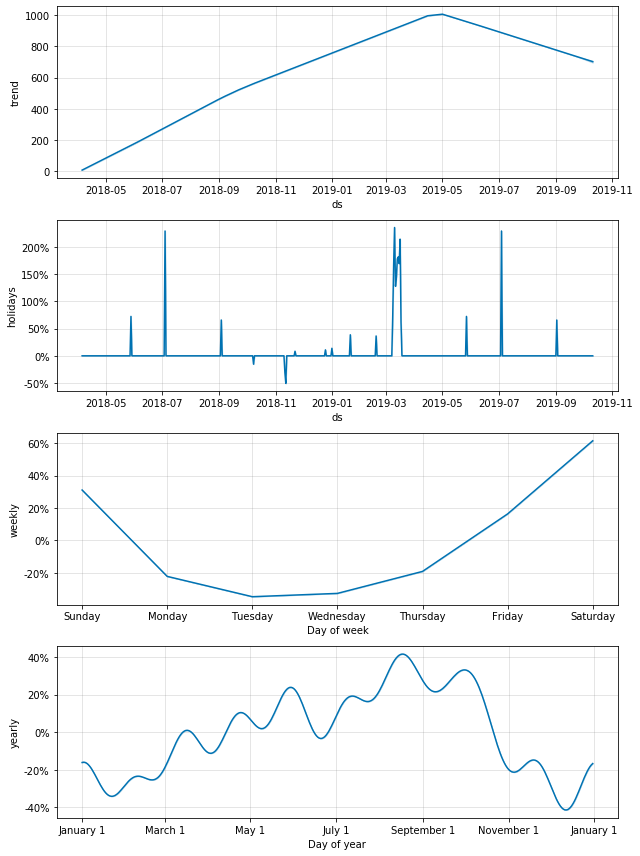

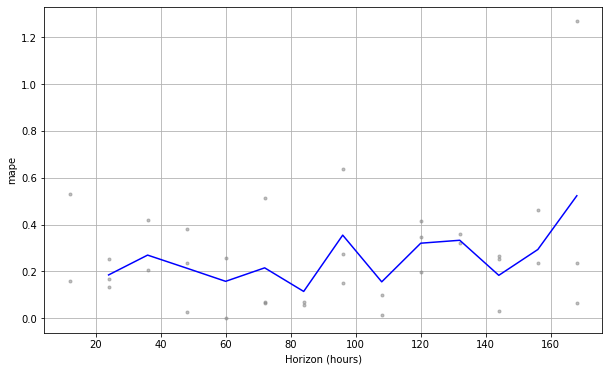

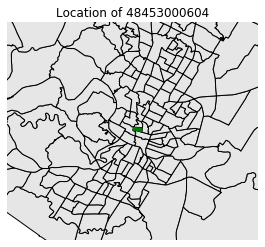

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000604 r2 score: 0.3262133004839838
MAPE: 0.23890914113506773


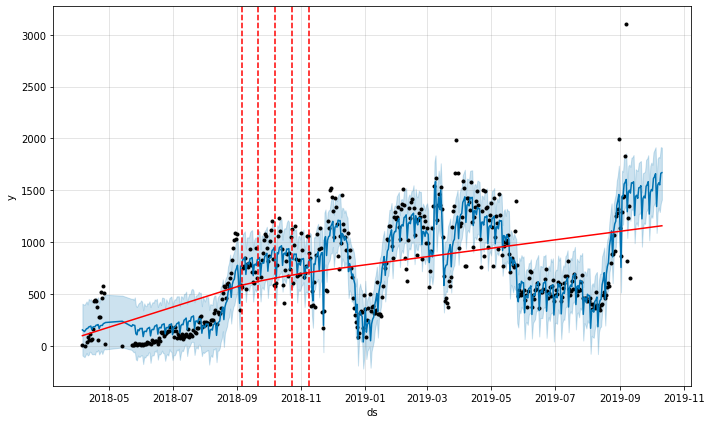

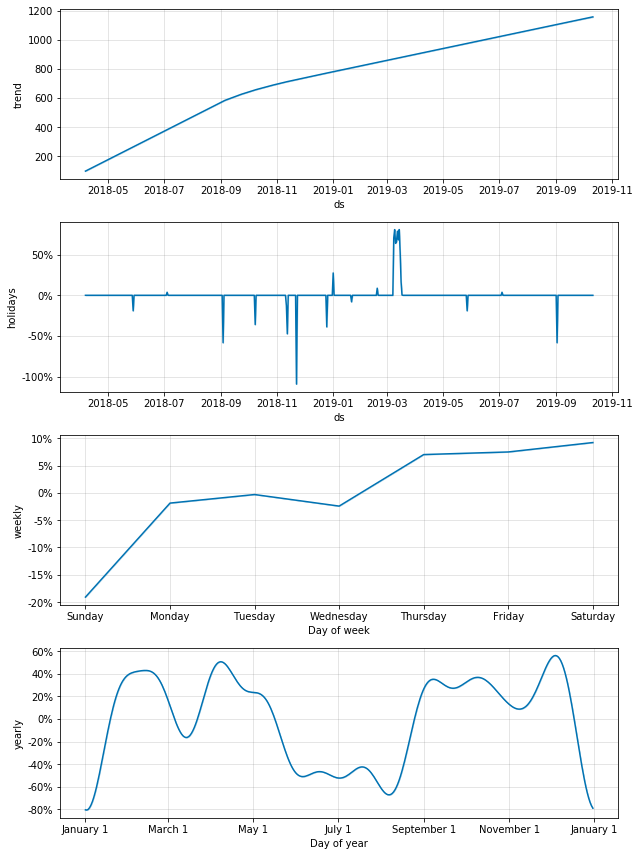

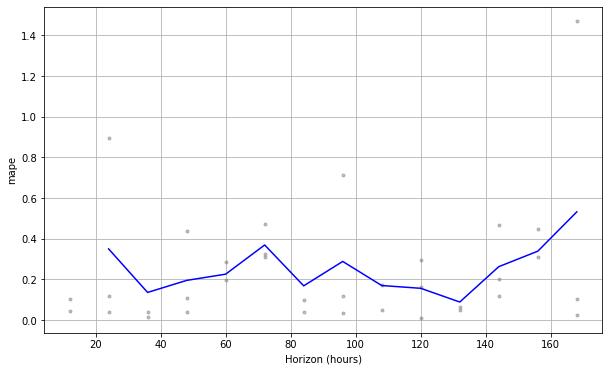

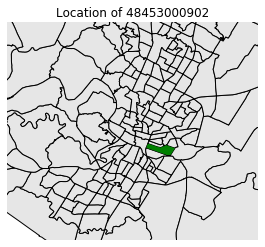

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000902 r2 score: 0.7502091494497275
MAPE: 0.19019803095254437


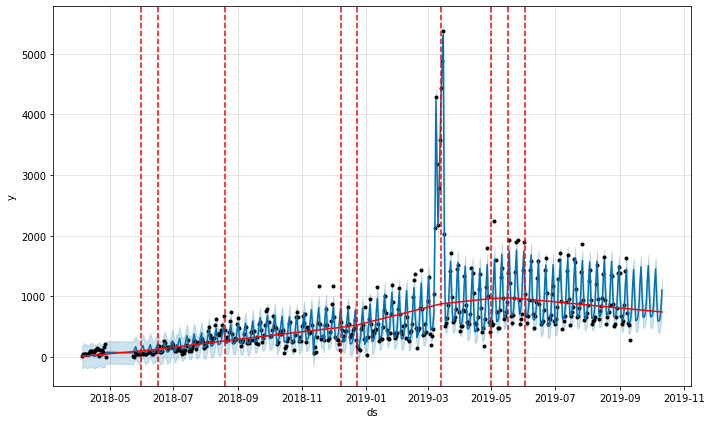

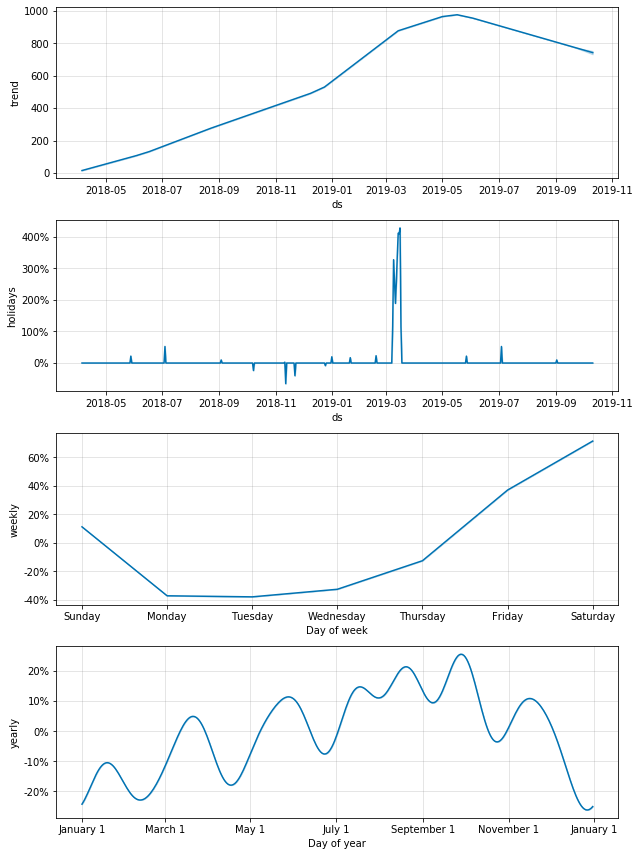

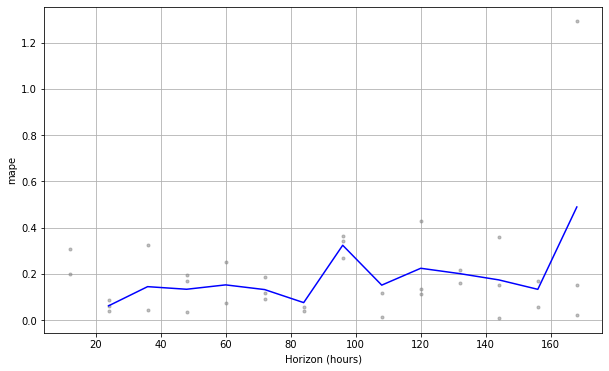

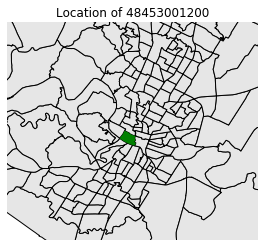

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-08-17 12:00:00 and 2019-09-04 00:00:00


48453001200 r2 score: 0.11430676087207081
MAPE: 0.18361393887855046


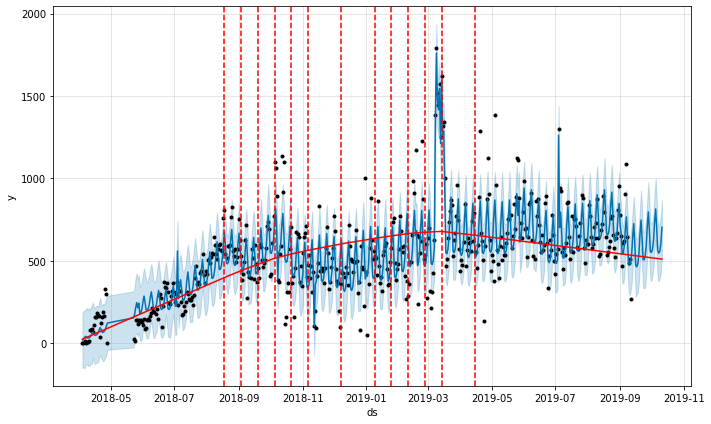

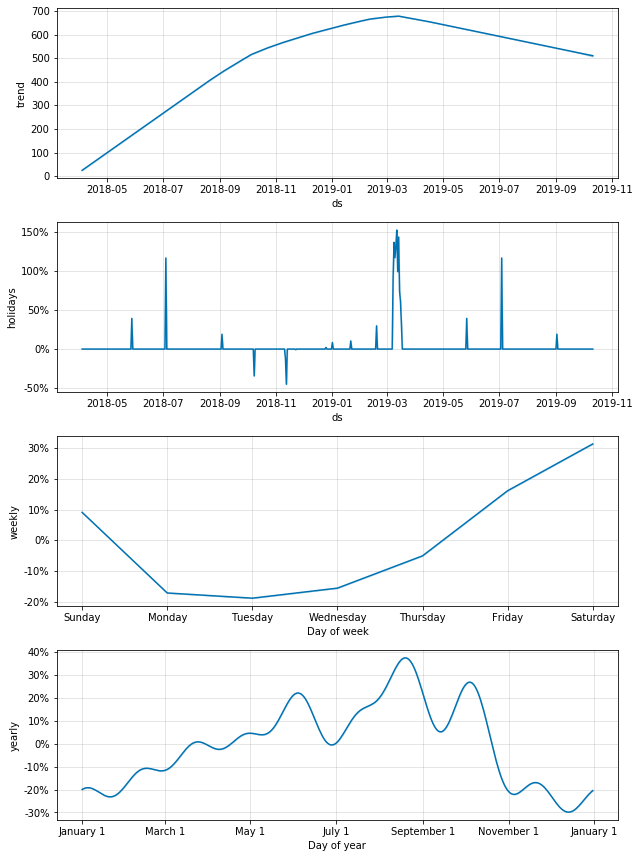

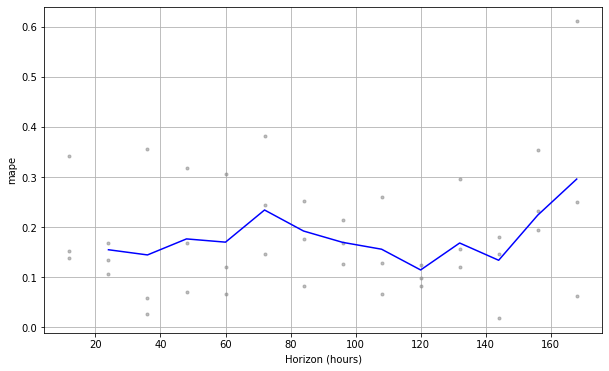

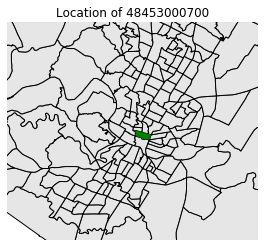

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000700 r2 score: 0.12907855137853153
MAPE: 0.5292290357394261


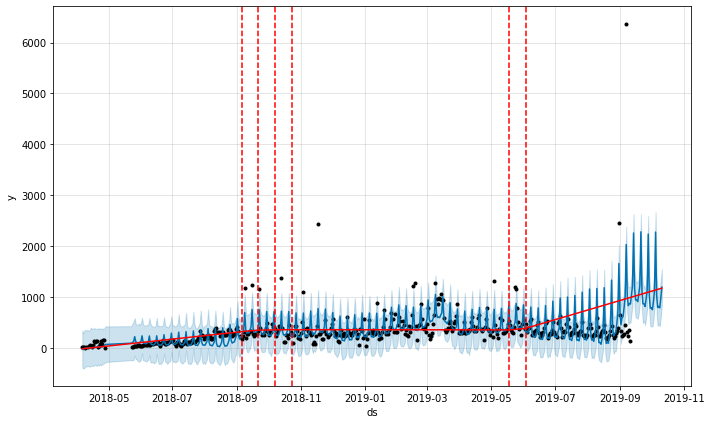

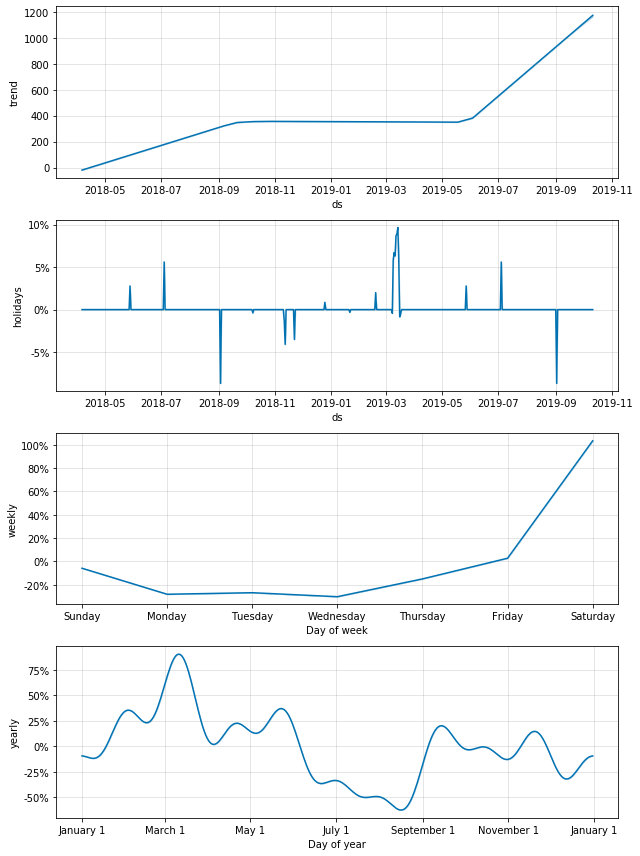

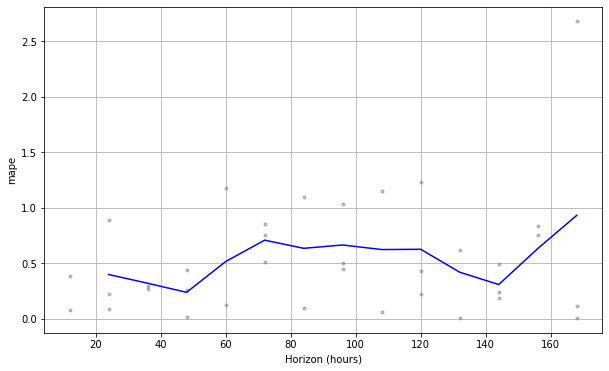

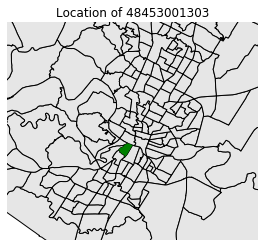

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453001303 r2 score: 0.2891048779620935
MAPE: 0.3559678380041233


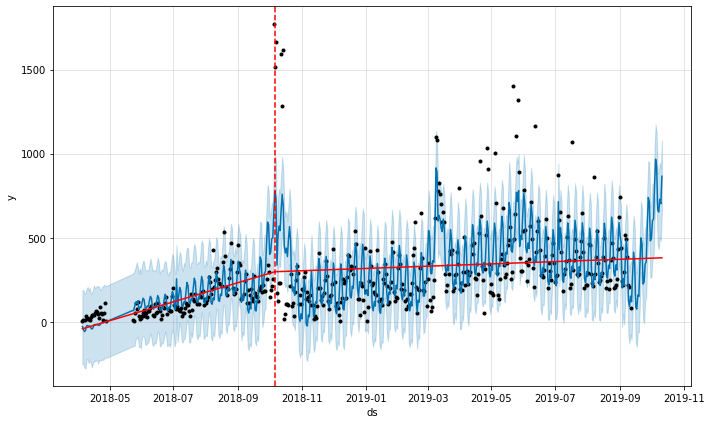

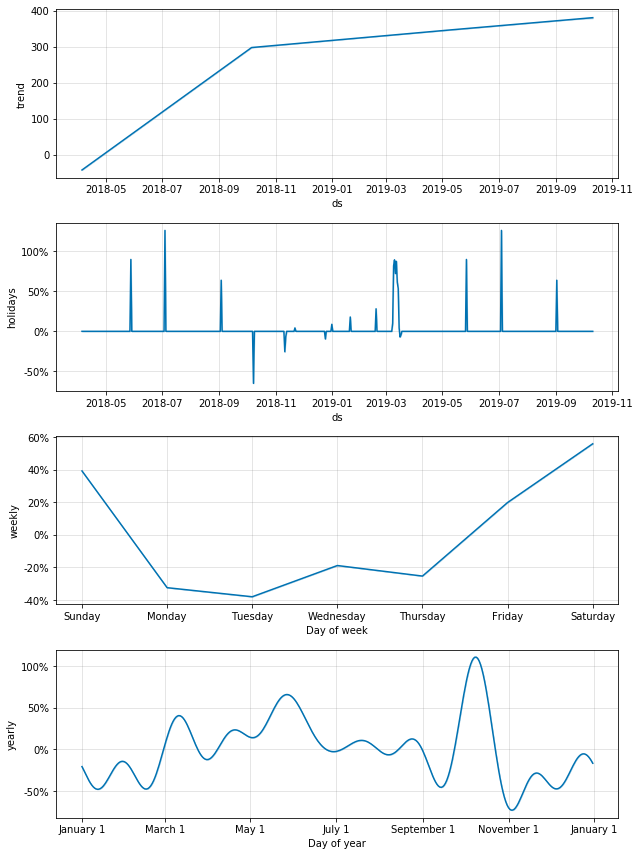

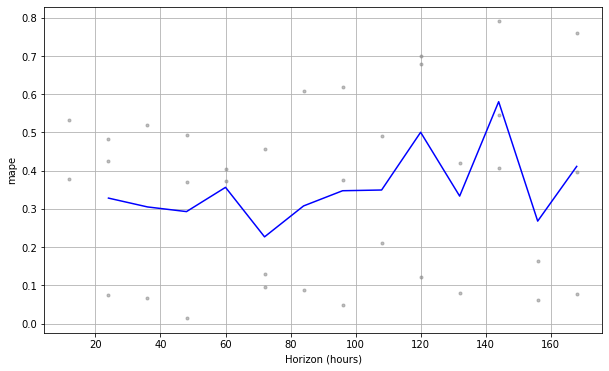

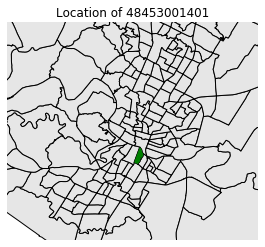

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453001401 r2 score: 0.4323027839432081
MAPE: 0.2709471091478427


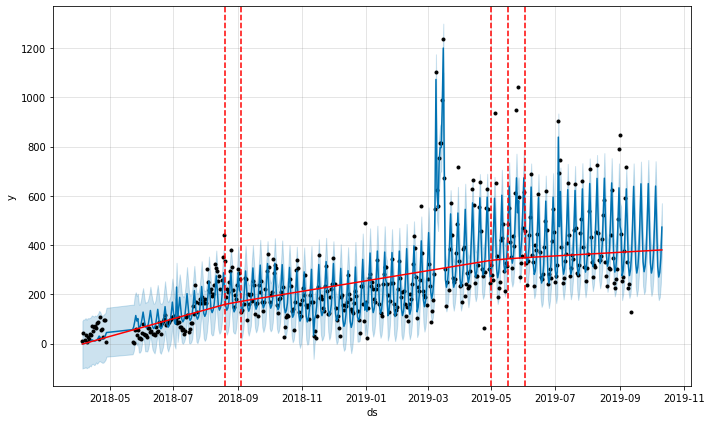

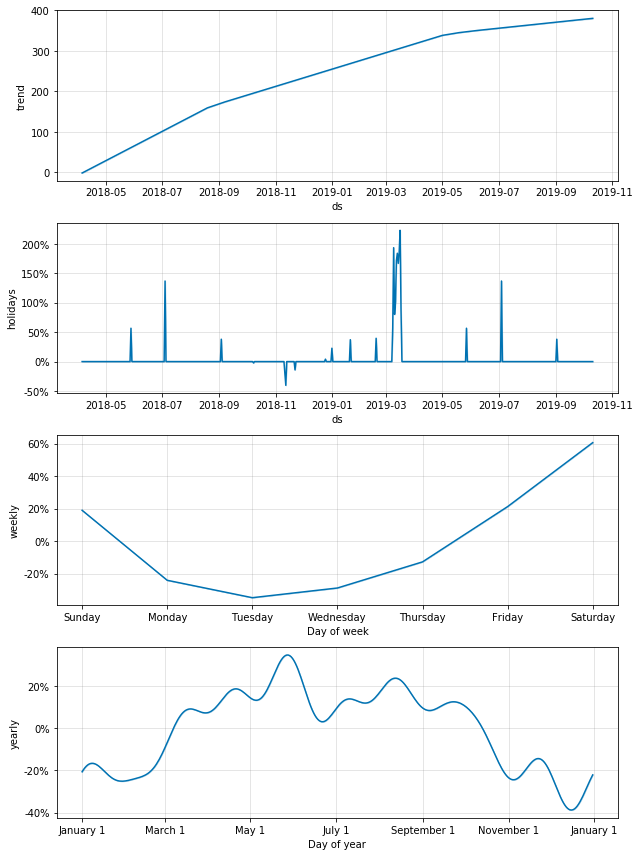

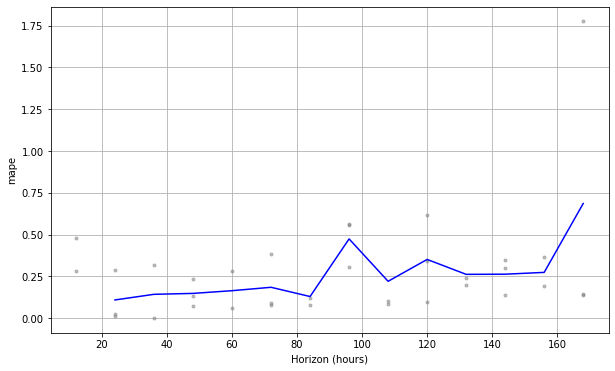

In [40]:
# initialize a dataframe for the forecasts and the confidence interval
forecasts = pd.DataFrame()
forecasts_80 = pd.DataFrame()

# Run prophet on the top 10 census tracts and save the results
for idx, ct in enumerate(census_starts.head(10).index.values):
    fbp, performance, df_cv, forecast = prophesy(ct, sample_rate='D')
    
    forecast = forecast.set_index('ds')
    forecasts[ct] = forecast['yhat']
    
    lower_bound = str(ct + '_lower')
    upper_bound = str(ct + '_upper')
    
    forecasts_80[lower_bound] = forecast['yhat_lower']
    forecasts_80[ct] = forecast['yhat']
    forecasts_80[upper_bound] = forecast['yhat_upper']

In [64]:
def plot_forecast(all_forecasts, aggressive_cts=False, conservative_cts=False, uncertain_df=False):
    # Create a dataframe of the forecasts
    future = all_forecasts.loc[pd.to_datetime('2019-9-10'):pd.to_datetime('2019-10-11')].fillna(0).clip(lower=0)

    # Check whether to use the upper or lower uncertainty boundary
    if aggressive_cts:
        for ct in aggressive_cts:
            future[ct] = uncertain_df[str(ct + '_upper')]
    if conservative_cts:
        for ct in conservative_cts:
            future[ct] = uncertain_df[str(ct + '_lower')]
    
    # Create a dataframe of the percentage of the total usage
    future_percent = future.div(future.sum(axis=1), axis=0)

    # register matplotlib converters.  This is a workaround for prophet working with pandas and matplotlib
    # https://github.com/pandas-dev/pandas/issues/27036 for details.  Future pandas/prophet versions may resolve.
    pd.plotting.register_matplotlib_converters()

    # plot area for each census track as a percentage
    future_percent.plot.area(stacked=True, figsize=(10,10))
    plt.xlabel('Date')
    plt.ylabel('Suggested portion of fleet')
    plt.title('Distribution of fleet percentages over forecast period')
    
    return future_percent

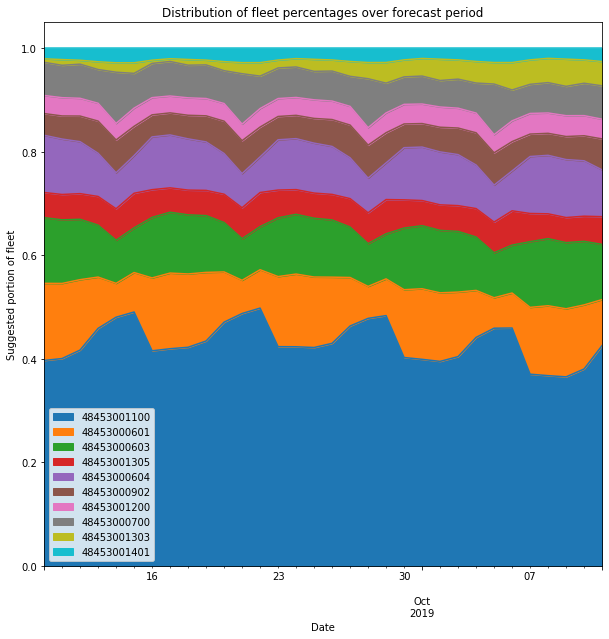

In [65]:
mean_forecast = plot_forecast(forecasts)

Suppose the provider wanted to adopt a more aggressive approach in some census tracts and a more conservative approach in others.  They could use the lower and upper bounds of the uncertainty interval to make their estimate

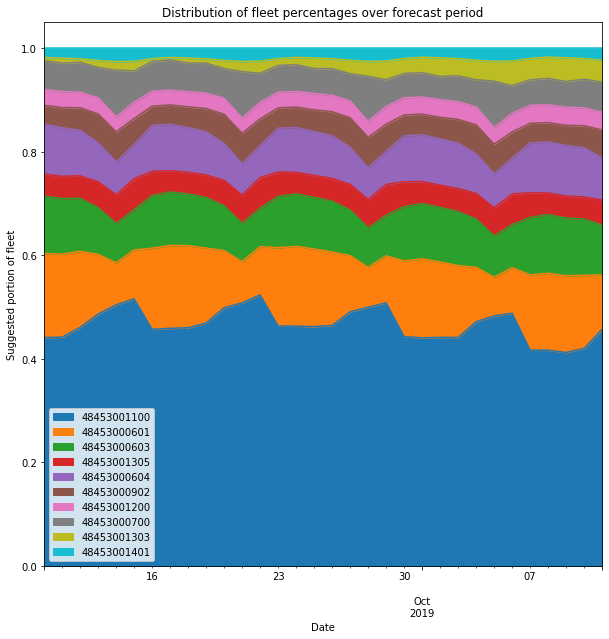

In [66]:
agg_example = plot_forecast(forecasts, aggressive_cts=['48453001100', '48453000601'], uncertain_df=forecasts_80)

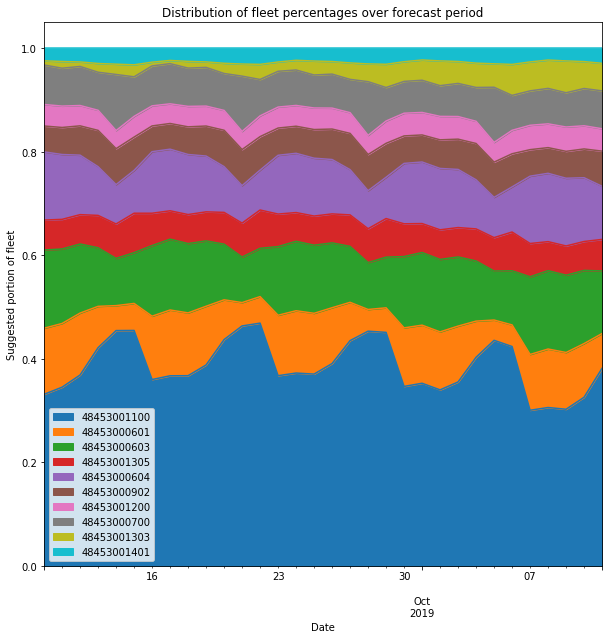

In [67]:
cons_example = plot_forecast(forecasts, conservative_cts=['48453001100', '48453000601'], uncertain_df=forecasts_80)

In [69]:
# use .loc to find the forecast for a particular day
print('Mean forecast:')
print(mean_forecast.loc[pd.to_datetime('2019-09-30')])

print('Agressive Example:')
print(agg_example.loc[pd.to_datetime('2019-09-30')])

print('Conservative Example:')
print(cons_example.loc[pd.to_datetime('2019-09-30')])

Mean forecast:
48453001100    0.402735
48453000601    0.130978
48453000603    0.118969
48453001305    0.054598
48453000604    0.100748
48453000902    0.045842
48453001200    0.037861
48453000700    0.053066
48453001303    0.032824
48453001401    0.022378
Name: 2019-09-30 00:00:00, dtype: float64
Agressive Example:
48453001100    0.443133
48453000601    0.146186
48453000603    0.104781
48453001305    0.048087
48453000604    0.088734
48453000902    0.040375
48453001200    0.033346
48453000700    0.046737
48453001303    0.028910
48453001401    0.019710
Name: 2019-09-30 00:00:00, dtype: float64
Conservative Example:
48453001100    0.346878
48453000601    0.113072
48453000603    0.137789
48453001305    0.063235
48453000604    0.116686
48453000902    0.053094
48453001200    0.043851
48453000700    0.061460
48453001303    0.038017
48453001401    0.025918
Name: 2019-09-30 00:00:00, dtype: float64


## Create a daily dashboard 

In [109]:
def dashboard(date, fleet_size, aggressive_cts=False, conservative_cts=False, uncertain_df=False):
    
    # plot forecast period
    forecast_percents = plot_forecast(forecasts, aggressive_cts, conservative_cts, uncertain_df)
    plt.axvline(x=pd.to_datetime(date), color='r')
    
    # Extract Values for today
    today = pd.DataFrame(forecast_percents.loc[pd.to_datetime(date)])
    
    # Plot Percentages for today
    today.plot(kind='barh', color='orange')
    plt.title(f'Distribution for {date}')
    plt.show()
    
    # Calculate number of scooters to deploy
    today.columns = ['Percent of Fleet']
    today['Number of Scooters to Deploy'] = (today['Percent of Fleet'] * fleet_size).astype('int32')
    print(today)

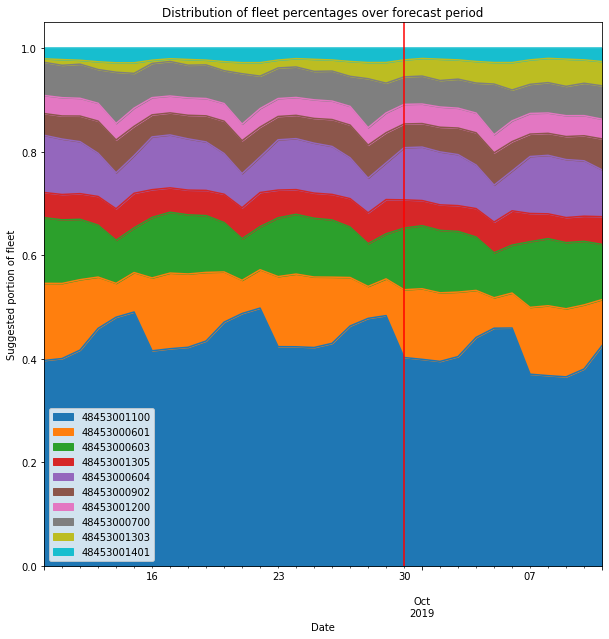

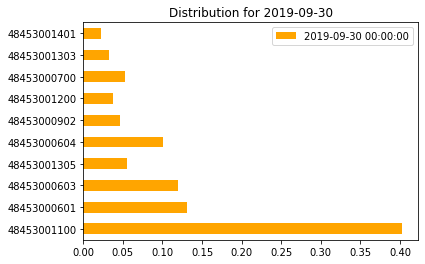

             Percent of Fleet  Number of Scooters to Deploy
48453001100          0.402735                           483
48453000601          0.130978                           157
48453000603          0.118969                           142
48453001305          0.054598                            65
48453000604          0.100748                           120
48453000902          0.045842                            55
48453001200          0.037861                            45
48453000700          0.053066                            63
48453001303          0.032824                            39
48453001401          0.022378                            26


In [110]:
dashboard('2019-09-30', fleet_size=1200)

## Citations
http://pavelbazin.com/post/linear-regression-hyperparameters/

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

Taylor SJ, Letham B. 2017. Forecasting at scale. PeerJ Preprints 5:e3190v2 https://doi.org/10.7287/peerj.preprints.3190v2